### ELO and Wine Ratings

Whether it be Uber, Amazon or Google, star ratings are everywhere we look these days.

For all their simplicity, they suffer from a range of problems. To name some: overrepresentation of extreme views in an average rating, different standards across users for what constitutes good/bad and anchoring effects of existing ratings. 

So is there an alternative? Well, maybe. In this analysis we are going to explore whether we can borrow from the game of chess to come up with a new type of wine rating - a variation of the ELO score used to evaluate the relative strength of chess players.

In [381]:
import pandas as pd
import numpy as np
import os
import json
import time
import datetime
from chessratings import uscf_elo
import wine_data_cleanup as wdc
from matplotlib import pyplot as plt
import matplotlib.transforms

pd.set_option('mode.chained_assignment', None)

First off, we need a dataset to work with. Wine rating app Vivino has been collecting star ratings for wines from its users for years. We have scraped all the wine reviews by the top 2,500 Vivino users in the Netherlands (see web_scraper.py for details).

The output files from our web scraper are JSONs. We will combine these JSONs into a single dataframe.

In [515]:
all_wine_reviews = []
for f in os.listdir('raw_data'):
    filename = 'raw_data/' + f
    with open(filename, 'r') as contents:
        user_wine_reviews = json.loads(contents.read())
        user_id = f.split('.')[0]
        scrape_date_unix = os.path.getmtime(filename)
        scrape_date = datetime.datetime.fromtimestamp(scrape_date_unix)
        for u in user_wine_reviews:
            u['reviewer'] = user_id
            u['scrape_date'] = scrape_date
            all_wine_reviews.append(u)

wine_review_df = pd.json_normalize(all_wine_reviews)
wine_review_df = wine_review_df[['wine_id', 'reviewer', 'review_date', 'review_time_ago', 'scrape_date', 'rating', 'vintage', 'wine_name', 'producer', 'region_name', 'country_name']]
wine_review_df.head()

,wine_id,reviewer,review_date,review_time_ago,scrape_date,vintage,rating,wine_name,producer,region_name,country_name
0,159717279,30112979,"Thu, Apr 29th at 16:24:15 UTC",2 days ago,2021-05-01 20:02:23.750630,2019,3.5,Chianti,Sensi,Chianti,Italy
1,157184020,30112979,"Wed, Apr 28th at 15:59:40 UTC",3 days ago,2021-05-01 20:02:23.750630,2018,3.0,La Chapelle de Pied Vaurias Côtes-du-Rhône,Vignerons de l'Enclave,Côtes-du-Rhône,France
2,160175069,30112979,"Mon, Apr 26th at 16:21:29 UTC",5 days ago,2021-05-01 20:02:23.750630,2019,4.0,Valpolicella Ripasso Classico Superiore,Villa Mondi,Valpolicella Ripasso,Italy
3,168019781,30112979,"Sun, Apr 25th at 15:56:30 UTC",6 days ago,2021-05-01 20:02:23.750630,2019,3.0,Vida Libre Blanco,Carlos Ruben,Vino de España,Spain
4,163444783,30112979,"Fri, Apr 23rd at 15:53:49 UTC",8 days ago,2021-05-01 20:02:23.750630,2020,3.5,MV Malbec,Mendoza Vineyards,Mendoza,Argentina


Our raw dataset consists of ~1 million wine reviews, with one row for each. A wine ID is defined for each wine and vintage (the same wine from different vintages will have different IDs). The review_date, review_time_ago and scrape_date columns are the raw data inputs we will need to determine when exactly a rating was given, since the review_date column does not include year. The star rating (out of 5) is captured in the rating column. The remaining columns include metadata about the wine (wine_name, producer, region_name, country_name). 

We can now use our raw datafile to create two tables: 

1. A table containing wine metadata that we can use to slice and dice our results later on
2. A table we can use to feed data into our ELO algorithm

In [516]:
wine_metadata = wine_review_df[['wine_id', 'vintage', 'wine_name', 'producer', 'region_name', 'country_name']].drop_duplicates()
wine_metadata.set_index('wine_id', inplace=True)
wine_metadata.head()

,vintage,wine_name,producer,region_name,country_name
wine_id,,,,,
159717279,2019,Chianti,Sensi,Chianti,Italy
157184020,2018,La Chapelle de Pied Vaurias Côtes-du-Rhône,Vignerons de l'Enclave,Côtes-du-Rhône,France
160175069,2019,Valpolicella Ripasso Classico Superiore,Villa Mondi,Valpolicella Ripasso,Italy
168019781,2019,Vida Libre Blanco,Carlos Ruben,Vino de España,Spain
163444783,2020,MV Malbec,Mendoza Vineyards,Mendoza,Argentina


Now, we can proceed with our second table. We first need to do some cleanup. 

We want a simplified table that contains one row per wine review, with only the necessary information about that review (the reviewer, review date and the rating out of 5).

In [45]:
wine_reviews_cleaned = wdc.clean_wine_reviews(wine_review_df).set_index('wine_id').reset_index()
wine_reviews_cleaned.drop_duplicates(inplace=True)
wine_reviews_cleaned.set_index('wine_id', inplace=True)

wine_reviews_cleaned.head()

,reviewer,rating,final_review_date
wine_id,,,
159717279,30112979,3.5,2021-04-29
157184020,30112979,3.0,2021-04-28
160175069,30112979,4.0,2021-04-26
168019781,30112979,3.0,2021-04-25
163444783,30112979,3.5,2021-04-23


Now for a closer look at these reviews. Can we learn anything about how these star ratings are distributed by reviewer?

<ipython-input-513-4a9332b58049>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


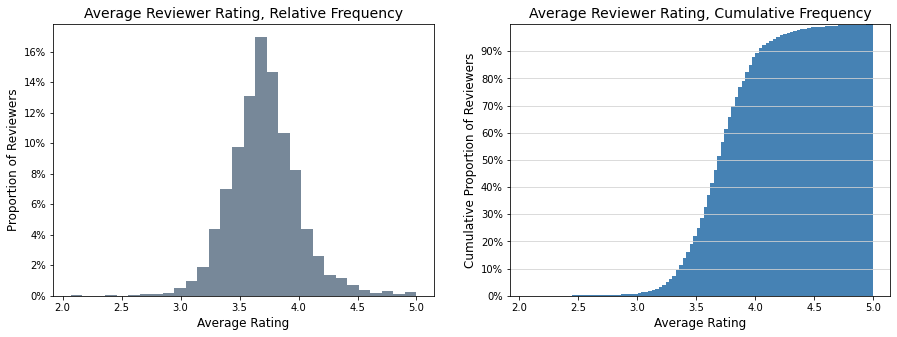

In [513]:
reviewer_distro = wine_reviews_cleaned.groupby('reviewer').agg({'rating': ['describe']})
plot_series = reviewer_distro[('rating', 'describe', 'mean')]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(plot_series, weights=np.zeros_like(plot_series) + 1/plot_series.size, bins=30, color='lightslategray')
plt.title('Average Reviewer Rating, Relative Frequency', fontsize=14)
plt.ylabel('Proportion of Reviewers', fontsize=12)
plt.xlabel('Average Rating', fontsize=12)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

plt.subplot(1, 2, 2)
plt.hist(plot_series, weights=np.zeros_like(plot_series) + 1/plot_series.size, bins=100, color='steelblue', cumulative=True)
plt.title('Average Reviewer Rating, Cumulative Frequency', fontsize=14)
plt.ylabel('Cumulative Proportion of Reviewers', fontsize=12)
plt.xlabel('Average Rating', fontsize=12)
plt.grid(color='lightgrey', linestyle='-', axis='y')
plt.ylim(0, 1)
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

plt.show()

This view of the data confirms some of the shortcomings of a system based on star ratings - most importantly that reviewers apply the star rating scale differently. Our dataset supports this, despite consisting of a group of reviewers that is geographically (and likely culturally) relatively homogenous. The 10% most critical reviewers award wines with less than 3.3/5 points, on average. The 10% most generous reviewers give upwards of 4/5 points on average. 

While it is possible that more critical reviewers are simply drinking worse wines, this is unlikely to explain for the entirety of the variance here. It stands to reason that some people simply give lower or higher ratings to wines, on average. This has a bearing on average wine ratings also. If a wine has been rated by generous individuals, it will have a higher score than if it has been rated by more critical users.


### From a star rating to ELO

We're almost ready to compute our ELO scores. We still, however, need to introduce a few key concepts and do a couple more data transformations. 

ELO scores are normally used to model skill levels in zero-sum games, most famously in chess. The difference in ratings between chess players serves as an indicator for who is more likely to win a match. Each match has one of three possible outcomes: win, draw or loss. Both players' scores are adjusted after a match based on the actual vs. expected outcome. Players will often compete in tournaments that consist of several matches. Here, score updates are typically done after a tournament has been conducted rather than after each individual match. 

We can circumvent many of the problems that plague star rating systems by framing a *reviewer's individual ratings on a given day* as a tournament of zero-sum matches. For this purpose, let us propose the following definitions:

- **Player**: a specific wine from a specific vintage
- **Match**: a head-to-head zero-sum comparison of two wines reviewed on a specific day by a specific individual
- **Tournament**: the collection of head-to-head matches by a specific individual on a specific day

The structure above relies on the basic assumption that we can trust a person to be ordinally consistent in the way they rank wines on a given day. If they give one wine 4 stars and another wine 5 on a given day, we can deduce that the 5-star wine was better than the 4-star one. 

#### Example

A hypothetical example to illustrate:

Reviewer John reviewed 3 different wines on May 20th, 2021: A, B and C.

- A: 5 stars
- B: 4 stars
- C: 4 stars

As a head-to-head zero sum game these results would look as follows:

- A vs. B: A wins, B loses
- A vs. C: A wins, C loses
- B vs. C: Draw

These three head-to-head **matches** can be grouped together in a **tournament**. We will run these tournaments chronologically. A wine (**player**) that has not participated in a tournament yet will receive a newly initialized ELO score, while a wine that has participated in tournaments in the past will enter a new tournament with its most recent ELO score. 

As we run each tournament, we will store information about each in a lookup table. This will allow us to study how wine ELO scores have evolved over time.


#### Quick note on ELO scores

Before we dive in, it is worth pointing out which implementation of the ELO algorithm we are using. We are using the most recent (2021) rules used by the US Chess Federation (USCF) as captured in the chessratings package.

Wines that are unrated (i.e. have not participated in any tournaments yet) are initialized with an ELO score of 1300, as would be the case for any adults above the age of 26 in the USCF rating scheme.  

Alright, enough explanation! Let's run the tournaments.

In [49]:
# score lookup table will store information about player performance that we need to initialize ratings as we run tournaments.
score_lookup_table_columns = ['wine_id', 'tournament_date', 'tournament_number', 'elo_rating', 'nr_games_played', 'nr_wins', 'nr_losses', 'reviewer']
score_lookup_table = pd.DataFrame(columns=score_lookup_table_columns)
all_results = wdc.run_tournaments(wine_reviews_cleaned, score_lookup_table)
all_results.to_csv('all_results.csv')
all_results.head()

,wine_id,tournament_date,tournament_number,elo_rating,nr_games_played,nr_wins,nr_losses,reviewer,nr_draws
0,1425299,2012-08-11,1,1300.0,2,0,0,259949,2.0
1,1541020,2012-08-11,1,1300.0,2,0,0,259949,2.0
2,1425289,2012-08-11,1,1300.0,2,0,0,259949,2.0
0,1442185,2012-08-25,1,1400.0,3,2,1,277053,0.0
1,1384827,2012-08-25,1,1050.0,3,0,2,277053,1.0


To better manage some of the volatility we may see in ELO scores, we will additionally compute a moving average (MA) ELO score, with a trailing window of 5 tournaments. This will allow us to smooth out the effect of individual tournaments skewing the score for any one wine, while preserving the ability to have wine scores trend up or down over time. 

In [517]:
all_results['ma_elo'] = all_results.groupby('wine_id')['elo_rating'].transform(lambda x: x.rolling(5, 1).mean())

Now that we have our MA ELO scores over time, we can start to explore the results. First, let's produce an overview of all the most recent MA ELO scores, by wine. We will eliminate any wines that have only competed in a handful of tournaments and matches.

The USCF can help here with a definition of what constitutes an 'established' rating: at least 25 matches. We will layer on top of this a minimum number of tournaments that we will require eligible wines to have competed in, to reduce the potential impact of a single user rating a wine very highly. 

In [526]:
group_by_wines = all_results.groupby('wine_id').agg({'tournament_date': 'max', 'nr_games_played': 'sum', 'nr_wins': 'sum', 'nr_draws': 'sum', 'nr_losses': 'sum', 'tournament_number': 'max'}).reset_index()
group_by_wines = pd.merge(group_by_wines, all_results[['wine_id', 'tournament_date', 'elo_rating', 'ma_elo']], how='left', on=['wine_id', 'tournament_date']).drop_duplicates(subset=['wine_id'])

group_by_wines = pd.merge(group_by_wines, wine_metadata, left_on='wine_id', right_index=True).drop_duplicates(subset=['wine_id'])
group_by_wines = group_by_wines[['wine_id', 'vintage', 'tournament_date', 'elo_rating', 'ma_elo', 'tournament_number', 'nr_games_played', 'nr_wins', 'nr_draws', 'nr_losses', 'wine_name', 'producer', 'region_name', 'country_name']]
group_by_wines['nr_draws'] = group_by_wines['nr_draws'].astype(int)

group_by_wines_bounded = group_by_wines.loc[(group_by_wines['tournament_number'] >= 10) & (results_grouped['nr_games_played'] >= 25)]
group_by_wines_bounded.sort_values(by=['ma_elo'], ascending=False).head(5)

,wine_id,vintage,tournament_date,elo_rating,ma_elo,tournament_number,nr_games_played,nr_wins,nr_draws,nr_losses,wine_name,producer,region_name,country_name
71727,152394404,2017,2021-03-27,2506.563862,2512.726519,22,180,118,57,5,Reserve Chenin Blanc,DeMorgenzon,Stellenbosch,South Africa
98553,156567925,2018,2021-04-09,2133.251400,2220.681122,10,57,32,15,10,Dão Reserva Branco,Cabriz,Dão,Portugal
165041,1934046,2011,2020-10-13,1940.599230,1952.337064,10,263,243,16,4,Campo del Drago Brunello di Montalcino,Castiglion del Bosco,Toscana,Italy
17107,1282334,2011,2021-04-10,1893.663354,1918.450114,14,75,53,15,7,Sassicaia,Tenuta San Guido,Bolgheri Sassicaia,Italy
159558,1787087,2005,2020-12-29,1918.165285,1903.667386,12,77,63,13,1,Gran Reserva 890,La Rioja Alta,Rioja,Spain


Ding ding! We have a winner! The 2017 Reserve Chenin Blanc by DeMorgenzon in Stellenbosch, South Africa. This wine has participated in 22 valid tournaments and has competed against a total of 180 other wines. Its moving average ELO is currently 2513, putting it well above the other wines in our dataset. 

Now, let's take a look at how our ELO metric compares to the star ratings that this wine has received. 


In [521]:
def retrieve_last_rating(wine_id, tournament_number):
    historical_ratings = all_results.loc[(all_results['tournament_number'] < tournament_number) & (all_results['wine_id'] == wine_id)]
    most_recent_rating = historical_ratings.loc[historical_ratings['tournament_number'] == max(historical_ratings['tournament_number'])].reset_index()
    most_recent_rating = most_recent_rating.at[0, 'elo_rating']
    return most_recent_rating

def score_head_to_head(rating, opponent_rating):
    if rating > opponent_rating:
        score = 1
    elif rating == opponent_rating:
        score = 0.5
    elif rating < opponent_rating:
        score = 0
    else:
        score = None
    return score

wine_id = '152394404'

wine_results = all_results.loc[all_results['wine_id'] == wine_id]
tournament_results = []
for index, row in wine_results.iterrows():
    tournament_result = all_results.loc[(all_results['reviewer'] == row['reviewer']) & (all_results['tournament_date'] == row['tournament_date'])]
    # retrieve the main wine's rating
    reviewer_date_ratings = wine_reviews_cleaned.loc[(wine_reviews_cleaned['final_review_date'] == row['tournament_date']) & (wine_reviews_cleaned['reviewer'] == row['reviewer'])]
    wine_rating = reviewer_date_ratings.at[wine_id, 'rating']
    for i, r in tournament_result.iterrows():
        if r['tournament_number'] > 1:
            opponent_initialized_elo = retrieve_last_rating(r['wine_id'], r['tournament_number'])
        else:
            opponent_initialized_elo = 1300
        opponent_star_rating = reviewer_date_ratings.at[r['wine_id'], 'rating']
        if isinstance(opponent_star_rating, float):
            score = score_head_to_head(wine_rating, opponent_star_rating)
            tournament_result_details = [row['tournament_number'], r['wine_id'], row['reviewer'], row['tournament_date'], opponent_initialized_elo, score]
            tournament_results.append(tournament_result_details)

tr = pd.DataFrame(tournament_results, columns=['tournament_number', 'wine_id', 'reviewer', 'tournament_date', 'initialized_elo', 'score'])
opponents = tr.loc[tr['wine_id'] != wine_id]

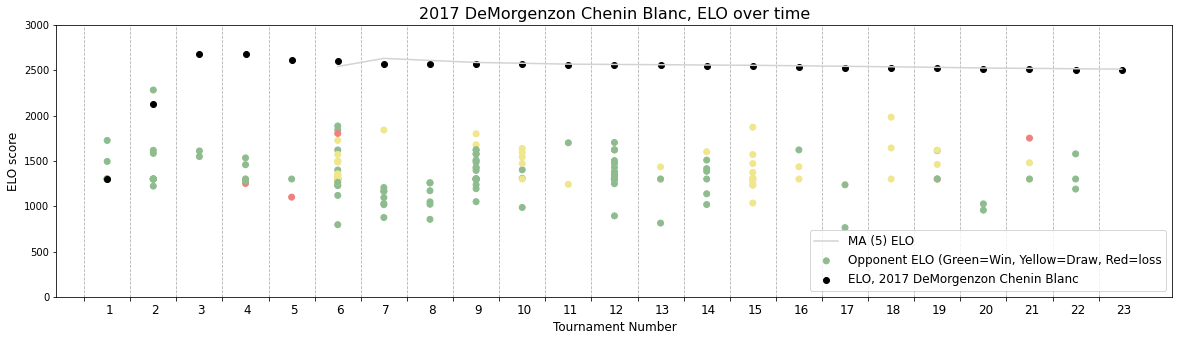

In [522]:
plt.figure(figsize=(20, 5))

colors = {0.0: 'lightcoral', 0.5: 'khaki', 1.0: 'darkseagreen'}

ax = plt.gca()
ax.xaxis.set_ticks(np.arange(min(opponents['tournament_number']) - 0.5, max(opponents['tournament_number']) + 1.5, 1.0))
ax.set_xticklabels(np.arange(1, max(opponents['tournament_number'])+2, 1), fontsize=12)
ax.grid(axis='x', linestyle='--')

ax.scatter(opponents['tournament_number'], opponents['initialized_elo'], c=opponents['score'].map(colors), label='Opponent ELO (Green=Win, Yellow=Draw, Red=loss')

ma_elo_shifted = [np.nan] * 4 + list(wine_results['ma_elo'])[4:]
ax.plot([i +1 for i in list(wine_results['tournament_number'])], ma_elo_shifted, color='lightgrey', label='MA (5) ELO')

main_elo_series = [1300] + list(wine_results['elo_rating'])
main_elo_series_tr = [1] + [1+ i for i in list(wine_results['tournament_number'])]
ax.scatter(main_elo_series_tr, main_elo_series, color='black', label='ELO, 2017 DeMorgenzon Chenin Blanc')

dx = 25/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

plt.xlabel('Tournament Number', fontsize=12)
plt.ylabel('ELO score', fontsize=12)
plt.ylim(0, 3000)

ax.legend(loc='lower right', fontsize=12)
plt.title('2017 DeMorgenzon Chenin Blanc, ELO over time', fontsize=16)
plt.show()

The plot above illustrates how the ELO score of our DeMorgenzon Chenin Blanc (black dots) evolved over the course of the 22 tournaments that it competed in. The colored dots indicate the ELO scores of the wines it competed against, with the color of the dot indicating the result of the head-to-head match: (green=win, yellow=draw, red=loss). 

In tournament 1, it was initialized with an ELO of 1300, as is the case for all unrated wines. The green dots indicate that it won all its matches in that tournament, and that its rating subsequently increased to about 2100. 

Let's take a closer look at the second tournament it participated in to get a deeper understanding for the dynamics between star rating and ELO. 

In [523]:
tournament_2_opponents = opponents.loc[opponents['tournament_number'] == 2]
tournament_2_wine_info = tr.loc[(tr['wine_id'] == wine_id) & (tr['tournament_number'] == 2)]

tournament_2_details = pd.concat([tournament_2_opponents, tournament_2_wine_info])
tournament_2_details = pd.merge(tournament_2_details, wine_reviews_cleaned, left_on=['wine_id', 'reviewer', 'tournament_date'], right_on=['wine_id', 'reviewer', 'final_review_date'])
tournament_2_details = pd.merge(tournament_2_details, wine_metadata, on='wine_id', how='left').drop_duplicates(subset='wine_id')

tournament_2_details[['wine_id', 'reviewer', 'initialized_elo', 'rating', 'wine_name', 'vintage', 'producer']].sort_values('rating', ascending=False)

,wine_id,reviewer,initialized_elo,rating,wine_name,vintage,producer
10,152394404,10523344,2125.781786,4.5,Reserve Chenin Blanc,2017,DeMorgenzon
0,21251689,10523344,1221.955536,4.0,Acinatico Amarone della Valpolicella Classico,2015,Stefano Accordini
1,154960489,10523344,2282.566746,4.0,Thanks Bianco,2017,di Lenardo
3,1356754,10523344,1300.000000,4.0,Carmes de Rieussec Sauternes,2009,Château Rieussec
5,144306921,10523344,1300.000000,4.0,Paradoxe,2016,Domaine de l'Arjolle
6,15351468,10523344,1300.000000,4.0,Franciacorta Emozione Brut,2014,Villa Franciacorta
7,155859370,10523344,1300.000000,4.0,Jakobi Sauvignon Blanc,2017,Gross
8,26894910,10523344,1300.000000,4.0,Blanc de Blancs Réserve Brut Champagne Grand C...,2014,De Sousa
9,1879218,10523344,1617.101617,4.0,Lalande-de-Pomerol,2010,Château Ame de Musset
2,30222063,10523344,1300.000000,3.5,L'Orme de Rauzan-Gassies Haut-Médoc,2012,Château Rauzan-Gassies


Our DeMorgenzon Chenin Blanc entered tournament 2 with an ELO rating of 2126. It faced 10 other wines, ranging in ELO between 1222 and 2283. It received a star rating of 4.5, higher than any other wine competing in the tournament. This translated into 10 outright wins and another jump in ELO rating to 2683. 

The rating jump (+553) here is high for a few specific reasons - firstly, our winning wine entered the tournament having only previously competed in 11 matches (tournament 1), and won all of these. As a consequence of the small sample size combined with a streak of only wins, the ELO rating algorithm - as per the specifications of the US Chess Federation - uses a 'special rating' formula to compute the rating adjustment. This special rating formula results in higher potential jumps, since it is used in situations where there is more uncertainty around a player's rating. The second reason the jump was so big is because our Chenin Blanc defeated the 2017 di Lenardo Thanks Bianco, a wine that had an ELO rating of 2283 at the time. Defeating players that are much stronger can result in bigger jumps in ELO. 

Before we move on, let's take a look at the reviewer responsible for tournament 2. Our winning wine was given a star rating of 4.5 - but how exceptional was this really?

In [524]:
reviewer_details = wine_reviews_cleaned.loc[wine_reviews_cleaned['reviewer'] == '10523344']
print('Average star rating by reviewer 10523344:', np.mean(reviewer_details['rating']))

reviewer_details = pd.merge(wine_reviews_cleaned['rating'].value_counts(normalize=True), reviewer_details['rating'].value_counts(normalize=True), left_index=True, right_index=True, how='left').reset_index()
reviewer_details.columns = ['star_rating', 'all_reviews', 'reviewer_10523344']

reviewer_details.sort_values('star_rating')

Average star rating by reviewer 10523344: 3.398014440433213


,star_rating,all_reviews,reviewer_10523344
7,1.0,0.005731,0.002708
8,1.5,0.004373,0.007220
6,2.0,0.022572,0.037906
4,2.5,0.040448,0.053249
2,3.0,0.166387,0.264440
1,3.5,0.277732,0.331227
0,4.0,0.353764,0.283394
3,4.5,0.092388,0.019856
5,5.0,0.036605,NaN


This output demonstrates that the reviewer in tournament 2 is generally more pessimistic than most other reviewers in our dataset. Their average rating is just shy of 3.4 stars. Looking back to our reviewer distribution earlier in this notebook, this puts this reviewer in the 20% most critical reviewers. This is further supported by the fact that only 2% of their ratings are 4.5 stars or above. In contrast, when looking across the ~1 million reviews in our *full* dataset, we can see that almost 13% of ratings given to wines are 4.5 stars or above. 

We can conclude that the star rating system doesn't really do justice to how highly our Chenin Blanc was assessed in tournament 2. Our ELO score, on the other hand, is able to control for reviewer 'strictness', and therefore generate a big lift in score as a result of this exceptional performance.

Our ELO score additionally controls for differences in how individual reviewers may apply ratings over time (becoming less/more strict). It only requires that reviewers are ordinally consistent with their wine ratings on a single day. ELO is also better able to capture changes in a wine's quality over time than an average star rating over the full lifetime of a wine. As a wine ages and gets better/worse, its ELO will evolve to reflect this.

It does appear that our ELO score addresses some fundamental issues that plague star ratings. So how should we use it? Let's take a step back and look at the difference between ELO and star ratings for *all* the wines in our dataset.

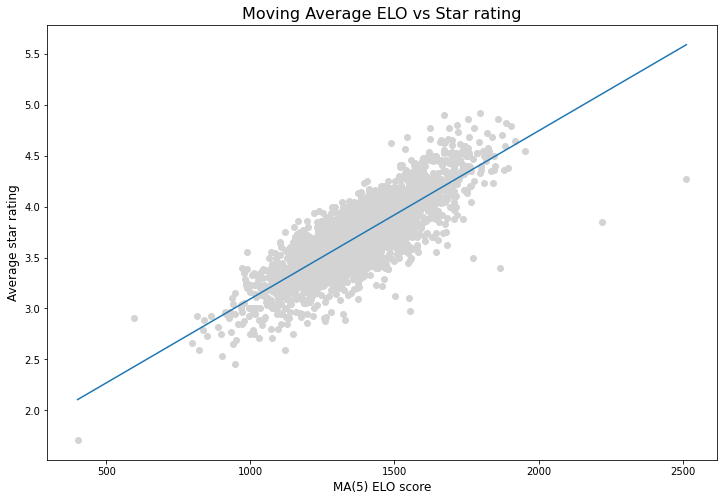

In [525]:
reviews_and_scores = pd.merge(all_results, wine_reviews_cleaned, left_on=['reviewer', 'wine_id', 'tournament_date'], right_on=['reviewer', 'wine_id', 'final_review_date']).drop_duplicates(subset=['wine_id', 'tournament_number'])
average_ratings = reviews_and_scores.groupby('wine_id')['rating'].mean().reset_index()
elo_vs_rating = pd.merge(average_ratings, group_by_wines_bounded, on='wine_id')

x = elo_vs_rating['ma_elo']
y = elo_vs_rating['rating']
plt.figure(figsize=(12, 8))
plt.scatter(x, y, color='lightgrey')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.title('Moving Average ELO vs Star rating', fontsize=16)
plt.xlabel('MA(5) ELO score', fontsize=12)
plt.ylabel('Average star rating', fontsize=12)
plt.show()

We can see that there is (as expected!) a strong positive correlation between the average star rating and moving average ELO. Wines with higher 5-star ratings generally have higher MA ELO scores.

The deviations from this correlation are more interesting. We can see that wines with an average rating of 3.5 stars can have MA ELO scores as low as 1000 or as high as 1700. These wines may be underserved by simple average star ratings, which can conceal their quality relative to other wines on the platform. The 2017 DeMorgenzon Chenin Blanc is a prime example: the right-most dot on the plot above, with a MA ELO that is much higher than its star rating would suggest. 

We can use a line of best fit (blue line) to indicate which wines are **outperforming** their average star rating. Wines to the right of this line have a higher MA ELO score than their average 5-point rating might suggest - and may therefore deserve a bit more love. A couple more examples:

- **2018 Dão Reserva Branco by Cadiz from Dão, Portugal**: MA ELO of 2221, average star rating of 3.9
- **2018 Klingenberg Spätburgunder by Weingut Stadt Klingenburg from Franken, Germany**: MA ELO of 1866, average star rating of 3.4
- **2015 Serego Alighieri Poderi del Bello Ovile Toscana by Masi from Tuscany, Italy**: MA ELO of 1773, average star rating of 3.5 


### Concluding Thoughts

A word of caution before we write off star ratings. 

Star rating systems are easy to understand. ELO will be much less intuitive to the average user. It also has shortcomings that the 5-point rating scale does not have. Importantly, ELO does not treat a 1 vs 5 star rating any differently than a 3 vs 3.5 star rating. The magnitude of preferences is lost in favor of a scheme that is zero-sum and more simplistic. 

Still, we have demonstrated that ELO provides value in ways that an average 5-star rating cannot. The above is an exploratory exercise to show the potential of this metric, but only starts to scratch the surface. The sample size used (wine reviews by top 2500 Vivino users in the Netherlands) is very small. The definition of what constitutes a valid tournament (wines rated on the same day by the same user) is also very constrictive and could be relaxed to allow for a larger number of head-to-head comparisons between wines. With more data and by finetuning some of the underlying assumptions, ELO scores will become more robust and reliable. We may also want to develop an ELO algorithm with parameters that are purpose-built to rate wines, rather than using the exact system implemented in the world of chess. 

So how about this, for now: let's use ELO *in addition* to the average star rating. And discover some hidden gems such as the 2017 DeMorgenzon Reserve Chenin Blanc in the process! 